<a href="https://colab.research.google.com/github/camilodlt/rtidy-python/blob/main/Computer%20vision/CIFAR/Customizing_hyper_parameter_tuning_in_AutoKeras_Blocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Customizing AutoKeras Blocks**

In [1]:
#%%capture
#!pip install tensorflow==2.4.1
#!pip install autokeras==1.0.12

In [2]:
%%capture
!pip install tensorflow==2.3.0
!pip install autokeras==1.0.16
!pip install keras_tuner==1.0.3

In [11]:
import keras_tuner
keras_tuner.__version__

'1.0.3'

In [12]:
# import the python packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Layer, Dense, ReLU, Softmax, MaxPooling2D, Flatten, Conv2D

import autokeras as ak

from typing import Optional
from typing import Union

import tensorflow as tf
from kerastuner.engine import hyperparameters
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.python.util import nest

from autokeras import keras_layers
from autokeras.blocks import reduction
from autokeras.engine import block as block_module
from autokeras.utils import layer_utils
from autokeras.utils import utils

print( "tf.__version__:", tf.__version__ )
print( "ak.__version__:", ak.__version__ )

tf.__version__: 2.3.0
ak.__version__: 1.0.16


## Load and prepare cifar10 dataset

#### Load dataset

In [13]:
# Load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

from sklearn.utils import resample
x_train, y_train = resample(x_train, y_train, n_samples=10000, replace=False, random_state=0)


#### Prepare data

In [14]:
# scale
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# reshape
x_train = x_train.reshape(-1, 32, 32, 3)
x_test = x_test.reshape(-1, 32, 32, 3)

## Customize a CNN AutoKeras Block


In [15]:
class myConvBlock(ak.Block):

    def build(self, hp, inputs=None):
        inputs = tf.nest.flatten(inputs)
        input_node = inputs[0]
        output_node = input_node

        # Set a hyperparameter kernel_size, which is selected from [3, 7] wiht step 2.
        kernel_size = hp.Int(name='kernel_size', min_value=3, max_value=7, step=2)
        # Set a hyperparameter filters, which is selected from [32, 256] wiht step 32.
        filters = hp.Int(name='n_filters', min_value=32, max_value=256, step=32)

        # Use a Conv2D layer to process the inputs with the tunable hyperparameters kernel_size and filters
        output_node= Conv2D(filters=filters, kernel_size= kernel_size)(input_node)
        return output_node


## Build a AutoML pipeline

In [28]:
# keras tuner --- 

hp = keras_tuner.HyperParameters()

# Model Arch --- 
inputs = ak.ImageInput()
# Set the block ---
inputs_tf = tf.keras.Input(shape=(32,32,3))
myConvBlock().build(hp,inputs_tf)

x = ak.Normalization()(inputs)
x = ak.ImageAugmentation()(x)
# Build an AutoML pipeline using the cusomized AutoKeras block myConvBlock 
x= myConvBlock()(x)
x= myConvBlock()(x)
x= myConvBlock()(x)
x= myConvBlock()(x)

# Classifier ---
outputs = ak.ClassificationHead(dropout=0.3)(x)

#### Search pipelines

In [29]:
clf = ak.AutoModel(
    inputs=inputs, 
    outputs=outputs,
    max_trials=10,
    overwrite=True,
    seed=43,
    tuner="greedy")
    # tuner="random")


clf.fit(x_train, y_train, epochs=3) # ,epochs=3, verbose=2
clf.tuner.search_space_summary()

Trial 10 Complete [00h 00m 35s]
val_loss: 1.400676965713501

Best val_loss So Far: 1.3419710397720337
Total elapsed time: 00h 06m 08s
INFO:tensorflow:Oracle triggered exit
Epoch 1/3
1563/1563 [==============================] - 9s 6ms/step - loss: 1.6930 - accuracy: 0.3935
Epoch 2/3
1563/1563 [==============================] - 9s 6ms/step - loss: 1.4528 - accuracy: 0.4914
Epoch 3/3
1563/1563 [==============================] - 9s 6ms/step - loss: 1.3954 - accuracy: 0.5167
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets
Search space summary
Default search space size: 17
image_augmentation_1/translation_factor (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.1], 'ordered': True}
image_augmentation_1/horizontal_flip (Boolean)
{'default': True, 'conditions': []}
image_augmentation_1/vertical_flip (Boolean)
{'default': True, 'conditions': []}
image_augmentation_1/rotation_factor (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.1], 'ordered': True}
i

## Retrain and explore model

In [30]:
# Get the summarized results during the tuning process (return the best 10 models if existed)
clf.tuner.results_summary()

Results summary
Results in ./auto_model
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
image_augmentation_1/translation_factor: 0.0
image_augmentation_1/horizontal_flip: True
image_augmentation_1/vertical_flip: False
image_augmentation_1/rotation_factor: 0.0
image_augmentation_1/zoom_factor: 0.1
image_augmentation_1/contrast_factor: 0.0
my_conv_block_2/kernel_size: 3
my_conv_block_2/n_filters: 32
my_conv_block_3/kernel_size: 3
my_conv_block_3/n_filters: 32
my_conv_block_4/kernel_size: 3
my_conv_block_4/n_filters: 32
my_conv_block_5/kernel_size: 3
my_conv_block_5/n_filters: 256
classification_head_1/spatial_reduction_1/reduction_type: global_max
optimizer: adam
learning_rate: 0.001
Score: 1.3419710397720337
Trial summary
Hyperparameters:
image_augmentation_1/translation_factor: 0.0
image_augmentation_1/horizontal_flip: True
image_augmentation_1/vertical_flip: False
image_augmentation_1/rotation_factor: 0.0
image_augmentation_1/zoom_fact

In [31]:
#Retrieve best model
best_model = clf.export_model()
best_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 32, 32, 3)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 3)         7         
_________________________________________________________________
random_flip (RandomFlip)     (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)       

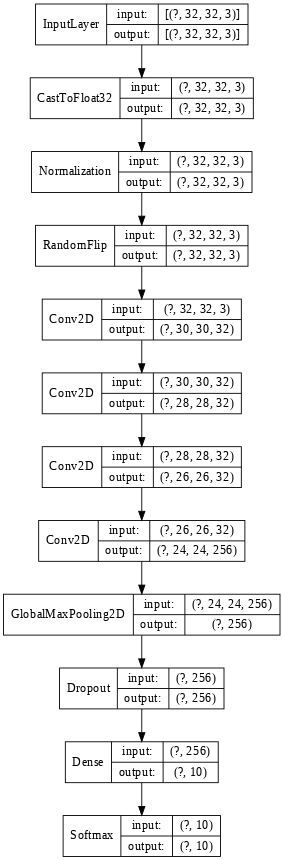

In [32]:
# Converts a Keras model to dot format and plot an image
tf.keras.utils.plot_model(best_model, show_layer_names=False, show_shapes=True, expand_nested=True, dpi=64)

#### Retrain the searched model

In [33]:
(x_train, y_train), (x_test, y_test) =  cifar10.load_data()
# scale
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# reshape
x_train = x_train.reshape(-1, 32, 32, 3)
x_test = x_test.reshape(-1, 32, 32, 3)
print('Training image shape:', x_train.shape)
print('Training label shape:', y_train.shape)
print('Testing image shape:', x_test.shape)
print('Testing label shape:', y_test.shape)

# compile the model and train the model
best_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
best_model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.20)

Training image shape: (50000, 32, 32, 3)
Training label shape: (50000, 1)
Testing image shape: (10000, 32, 32, 3)
Testing label shape: (10000, 1)
Epoch 1/10
625/625 [==============================] - 5s 8ms/step - loss: 1.3202 - accuracy: 0.5425 - val_loss: 1.1754 - val_accuracy: 0.6044
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 1.2790 - accuracy: 0.5612 - val_loss: 1.1634 - val_accuracy: 0.6108
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 1.2718 - accuracy: 0.5647 - val_loss: 1.1389 - val_accuracy: 0.6158
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 1.2518 - accuracy: 0.5708 - val_loss: 1.2160 - val_accuracy: 0.5895
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 1.2432 - accuracy: 0.5739 - val_loss: 1.1995 - val_accuracy: 0.5918
Epoch 6/10
625/625 [==============================] - 5s 8ms/step - loss: 1.2309 - accuracy: 0.5757 - val_loss: 1.1498 - val_accuracy: 0.6110
Ep

#### Evaluate the searched model

In [34]:
init=10
inc= 4

In [43]:
best_model.fit(x_train, y_train, epochs=init+inc, batch_size=64, validation_split=0.10, initial_epoch=init)
init+=inc

Epoch 43/46
704/704 [==============================] - 6s 8ms/step - loss: 1.0993 - accuracy: 0.6238 - val_loss: 1.0381 - val_accuracy: 0.6526
Epoch 44/46
704/704 [==============================] - 6s 8ms/step - loss: 1.0982 - accuracy: 0.6263 - val_loss: 1.0187 - val_accuracy: 0.6522
Epoch 45/46
704/704 [==============================] - 6s 8ms/step - loss: 1.0974 - accuracy: 0.6257 - val_loss: 1.0287 - val_accuracy: 0.6486
Epoch 46/46
704/704 [==============================] - 6s 8ms/step - loss: 1.1007 - accuracy: 0.6262 - val_loss: 1.0315 - val_accuracy: 0.6456


In [44]:
# evaluate the model
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=1)
print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 1.0314 - accuracy: 0.6529
Test loss:  1.031402349472046
Test accuracy:  0.652899980545044
